In [ ]:
''' 
# try some multithread execution for raxml to speed up the pre-processing step
import os
import subprocess
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
from tree_stats_init import start_parallel

count = 0
def run_raxml(subdir):
    print(count, ' == ', subdir, '\n')

# Specify the parent directory containing subdirectories with input files
parent_directory = "./data/test_data/"

# Get a list of subdirectories
subdirectories = [os.path.join(parent_directory, subdir) for subdir in os.listdir(parent_directory) if os.path.isdir(os.path.join(parent_directory, subdir))]

# Specify the number of parallel jobs
num_parallel_jobs = 2

# Run jobs in parallel using ThreadPoolExecutor
with ProcessPoolExecutor(max_workers=num_parallel_jobs) as executor:
    executor.map(start_parallel, subdirectories)
    count += 1
 '''

In [1]:
from tree_stats_init import start, parse_and_group_features, start_parallel
ds_path = './data/validation_data/'
#ds_path = './data/test_data/'
#ds_path = './data/training_data/'
#ds_path = './data/additional_training_data/'
#start(ds_path)

ds_path = parse_and_group_features(ds_path)
print(ds_path)

/Users/mihaid/Coding-Projects/thesis/DL_Phylo_Opt/Utils/RF_learning_algorithm.py:178: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_ds], join='inner', axis=0)
/Users/mihaid/Coding-Projects/thesis/DL_Phylo_Opt/Utils/RF_learning_algorithm.py:178: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_ds], join='inner', axis=0)
/Users/mihaid/Coding-Projects/thesis/DL_Phylo_Opt/tree_stats_init.py:228: DtypeWarning: Columns (5) have mixed types. Specify dtype opti

Index(['prune_name', 'rgft_name', 'orig_ds_ll', 'll', 'time', 'd_ll_prune',
       'edge_length', 'longest_branch', 'tbl_pruned', 'tbl_remaining',
       'name2ntaxa_pruned', 'name2ntaxa_remaining', 'longest_pruned',
       'longest_remaining', 'orig_ds_id', 'orig_ds_tbl'],
      dtype='object')


/Users/mihaid/Coding-Projects/thesis/DL_Phylo_Opt/tree_stats_init.py:231: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_rgft_moves = pd.read_csv(df_rgft_features, dtype=types_dict, index_col='iteration')


Index(['prune_name', 'rgft_name', 'orig_ds_ll', 'll', 'time', 'edge_length',
       'longest_branch', 'tbl_pruned', 'tbl_remaining', 'name2ntaxa_pruned',
       'name2ntaxa_remaining', 'longest_pruned', 'longest_remaining',
       'topology_dist_between', 'tbl_dist_between', 'res_tree_edge_length',
       'orig_ds_id', 'orig_ds_tbl'],
      dtype='object')
./data/validation_data/learning_all_moves.csv


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from Utils.defs_PhyAI import FEATURES, GROUP_ID, FEATURES_PRUNE, FEATURES_RGFT, types_dict, LABEL, FEATURES_MERGED,PROJECT_PATH, SCORES_PER_DS, DATA_WITH_PREDS, SEP
from Utils.RF_learning_algorithm import fit_transformation, extract_scores_dict, print_and_index_results

In [4]:
def plot_prediction(y_test, y_pred):
	# Plot Predictions vs. Actual values
	plt.figure(figsize=(10, 6))
	plt.scatter(y_test, y_pred, alpha=0.3)
	plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--k')
	plt.xlabel('Actual')
	plt.ylabel('Predicted')
	plt.title('Actual vs. Predicted Values')
	plt.show()

def plot_importance(f_imp, oob, features):
	# Feature Importances
	feature_importances = pd.Series(f_imp, index=features)
	feature_importances_sorted = feature_importances.sort_values(ascending=False)

	plt.figure(figsize=(10, 6))
	feature_importances_sorted.plot(kind='bar')
	plt.xlabel('Features')
	plt.ylabel('Importance')
	plt.title('Feature Importances')
	plt.show()

	# Display OOB Score
	print(f"OOB Score: {oob:.4f}")

In [25]:
from sklearn.ensemble import RandomForestRegressor
from Utils.defs_PhyAI import KFOLD, N_ESTIMATORS
VALSET_FEATURES_LABEL = './data/test_data/learning_all_moves.csv'

def split_features_label(df, move_type, features):
	attributes_df = df[features].reset_index(drop=True)
	label_df = df[LABEL.format(move_type)].reset_index(drop=True)
	x = np.array(attributes_df)
	y = np.array(label_df).ravel()

	return x, y

def score_rank(df_by_ds, sortby, locatein, random, scale_score):
	'''
	find the best tree in 'sortby' (e.g., predicted as the best) foreach dataset and locate its rank in 'locatein' (e.g., y_test)
	'''
	#print(df_by_ds.columns)
	best_pred_ix = df_by_ds[sortby].idxmax()    # changed min to max!
	
	if random:
		best_pred_ix = np.random.choice(df_by_ds[sortby].index, 1, replace=False)[0]
	temp_df = df_by_ds.sort_values(by=locatein, ascending=False).reset_index()   # changed ascending to False
	#print('temp_df ====== ', temp_df)
	best_pred_rank = min(temp_df.index[temp_df["iteration"] == best_pred_ix].tolist())
	best_pred_rank += 1  # convert from pythonic index to position
	
	if scale_score:
		best_pred_rank /= len(df_by_ds[sortby].index)   # scale the rank according to rankmax
		best_pred_rank *= 100

	print("best_pred_rank === ", best_pred_rank)
	return best_pred_rank

def ds_scores(df, move_type, random, scale_score):
	rank_pred_by_ds, rank_test_by_ds = {}, {}

	label = LABEL.format(move_type)
	sp_corrs = []
	grouped_df_by_ds = df.groupby(FEATURES[GROUP_ID], sort=False)
	for group_id, df_by_ds in grouped_df_by_ds:
		rank_pred_by_ds[group_id] = score_rank(df_by_ds, "pred", label, random, scale_score)
		rank_test_by_ds[group_id] = score_rank(df_by_ds, label, "pred", random, scale_score)
		
		temp_df = df_by_ds[[label, "pred"]]
		sp_corr = temp_df.corr(method='spearman').iloc[1,0]
		if sp_corr:
			sp_corrs.append(sp_corr)
		else:
			sp_corrs.append(None)
	
	return rank_pred_by_ds, rank_test_by_ds, sp_corrs

def apply_RFR(df_test, df_train, move_type, features):
	X_train, y_train = split_features_label(df_train, move_type, features)
	X_test, y_test = split_features_label(df_test, move_type, features)

	regressor = RandomForestRegressor(n_estimators=N_ESTIMATORS, max_features=0.33, oob_score=True).fit(X_train, y_train) # 0.33=nfeatures/3. this is like in R (instead of default=n_features)
	y_pred = regressor.predict(X_test)
	#print(X_test)
	#print("==== apply_RFR : ", y_pred)
	oob = regressor.oob_score_
	f_imp = regressor.feature_importances_
	plot_prediction(y_test, y_pred)
	plot_importance(f_imp, oob, features)
	return y_pred, oob, f_imp

def truncate(df):
	df = df.dropna()
	groups_ids = df[FEATURES[GROUP_ID]].unique()
	kfold = len(groups_ids) if KFOLD=="LOO" else KFOLD
	assert len(groups_ids) >= kfold
	ndel = len(groups_ids) % kfold
	if ndel != 0:   # i removed datasets from the end, and not randomly. from some reason..
		for group_id in groups_ids[:-ndel-1:-1]:
			df = df[df[FEATURES[GROUP_ID]] != group_id]

	groups_ids = df[FEATURES[GROUP_ID]].unique()
	new_length = len(groups_ids) - ndel
	test_batch_size = int(new_length / kfold)
	print(kfold, ndel, groups_ids, new_length, test_batch_size )
	return df.reset_index(drop=True), groups_ids, test_batch_size

def cross_validation_RF(df, move_type, features, trans=False, validation_set=False, random=False, scale_score=False):
	df, groups_ids, test_batch_size = truncate(df)
	res_dict = {}
	oobs, f_imps, = [], []
	my_y_pred, imps = np.full(len(df), np.nan), np.full(len(df), np.nan)
	
	if not validation_set:
		if test_batch_size != 0:
			for low_i in groups_ids[::test_batch_size]:
				low_i, = np.where(groups_ids == low_i)
				low_i = int(low_i)
				up_i = low_i + test_batch_size
		
				test_ixs = groups_ids[low_i:up_i]
				train_ixs = np.setdiff1d(groups_ids, test_ixs)
				df_test = df.loc[df[FEATURES[GROUP_ID]].isin(test_ixs)]
				#print("df_test = ", df_test)
				df_train = df.loc[df[FEATURES[GROUP_ID]].isin(train_ixs)]
				#print("df_train = ", df_train)
				y_pred, oob, f_imp = apply_RFR(df_test, df_train, move_type, features)
		
				oobs.append(oob)
				f_imps.append(f_imp)
				my_y_pred[df_test.index.values] = y_pred       # sort the predictions into a vector sorted according to the respective dataset
			
		df["pred"] = my_y_pred
	
	else:     # namely if validation set strategy, and not cross validation
		df_train = df
		df_test = pd.read_csv(VALSET_FEATURES_LABEL, index_col='iteration')
		df_test = fit_transformation(df_test, move_type, trans).dropna()
		y_pred, oob, f_imp = apply_RFR(df_test, df_train, move_type, features)
		
		oobs.append(oob)
		f_imps.append(f_imp)
		df_test["pred"] = y_pred  # the predictions vec is the same lengths of test set
		df = df_test
	
	print("prediction : ", df["pred"])
	
	rank_pred_by_ds, rank_test_by_ds, corrs = ds_scores(df, move_type, random, scale_score)

	# averaged over cv iterations
	res_dict['oob'] = sum(oobs) / len(oobs)
	res_dict['f_importance'] = sum(f_imps) / len(f_imps)
	# foreach dataset (namely arrays are of lengths len(sampled_datasets)
	res_dict["rank_first_pred"] = rank_pred_by_ds
	res_dict["rank_first_true"] = rank_test_by_ds
	res_dict["spearman_corr"] = corrs
	
	
	return res_dict, df


In [23]:
#TODO remove
ds_path = './data/training_data/learning_all_moves.csv'
move_type = "merged"
st = "1"
validation_set = True #args.validation_set
transform_target = False #args.transform_target

df_learning = pd.read_csv(ds_path, dtype=types_dict, index_col='iteration')
df_learning = fit_transformation(df_learning, move_type, trans=transform_target)

features = FEATURES_PRUNE if move_type == "prune" else FEATURES_RGFT if move_type == "rgft" else FEATURES_MERGED
features = list(map(lambda x: x.replace('topology_dist_between_rgft', 'topology_dist_between'), features))
features = list(map(lambda x: x.replace('tbl_dist_between_rgft', 'tbl_dist_between'), features))
features = list(map(lambda x: x.replace('res_tree_edge_length_rgft', 'res_tree_edge_length'), features)) 
#features = list(set(features) - set(['topology_dist_between_rgft', 'tbl_dist_between_rgft', 'res_tree_edge_length_rgft']))

if FEATURES[GROUP_ID] in features:
	features.remove(FEATURES[GROUP_ID])
 
suf = "_{}_validation_set".format(st) if validation_set else "_{}".format(st)
iftrans = "" if not transform_target else "_ytransformed"
suf += iftrans
csv_with_scores = PROJECT_PATH + SEP + SCORES_PER_DS.format(str(len(features))+ suf)
csv_with_preds = PROJECT_PATH + SEP + DATA_WITH_PREDS.format(str(len(features)) + suf)

/var/folders/1s/5_jwsmtn2n54h333qvdtr32c0000gp/T/ipykernel_20207/1544689267.py:8: DtypeWarning: Columns (5,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_learning = pd.read_csv(ds_path, dtype=types_dict, index_col='iteration')


*@*@*@* scores for step_1_validation_set with 20 features are not available, thus applying learning
10 4 [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 22

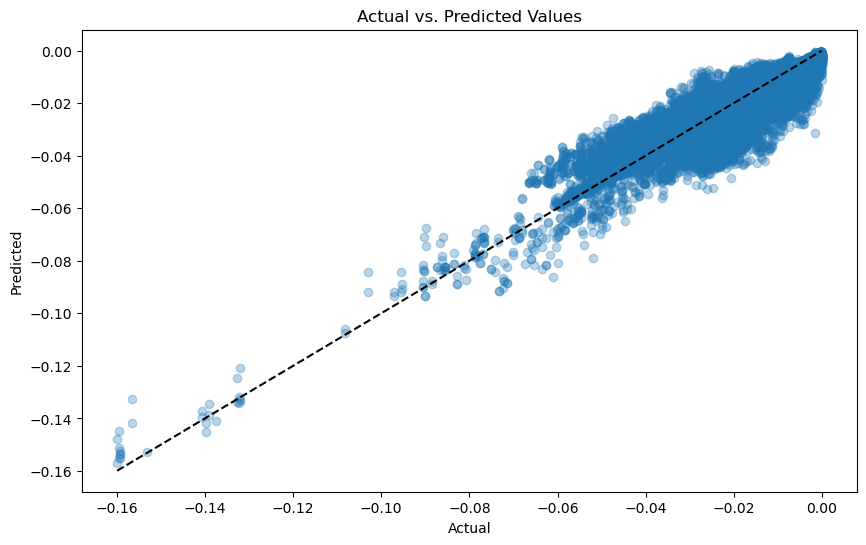

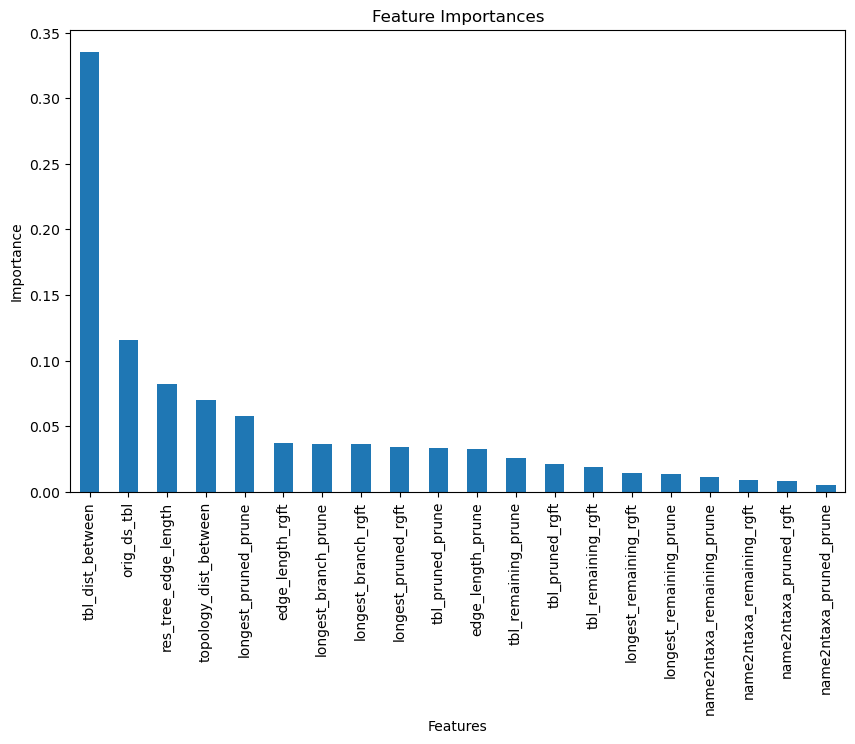

OOB Score: 0.9822
prediction :  iteration
2,0     -0.001373
2,1     -0.004385
2,2     -0.016542
2,3     -0.017019
2,4     -0.024473
           ...   
25,19   -0.018739
25,20   -0.009595
25,21   -0.006775
25,22   -0.007436
25,23   -0.004076
Name: pred, Length: 34962, dtype: float64
best_pred_rank ===  11
best_pred_rank ===  80
best_pred_rank ===  9
best_pred_rank ===  36
best_pred_rank ===  77
best_pred_rank ===  113
best_pred_rank ===  28
best_pred_rank ===  207
best_pred_rank ===  9
best_pred_rank ===  25
best_pred_rank ===  33
best_pred_rank ===  52
best_pred_rank ===  50
best_pred_rank ===  22
best_pred_rank ===  86
best_pred_rank ===  724
best_pred_rank ===  16
best_pred_rank ===  41
best_pred_rank ===  65
best_pred_rank ===  62
best_pred_rank ===  14
best_pred_rank ===  49
best_pred_rank ===  23
best_pred_rank ===  241
best_pred_rank ===  14
best_pred_rank ===  1307
best_pred_rank ===  16
best_pred_rank ===  2
best_pred_rank ===  24
best_pred_rank ===  90

sapearman corr:
mean: 0.

In [26]:
if not os.path.exists(csv_with_scores) or validation_set:
	print("*@*@*@* scores for step{} with {} features are not available, thus applying learning".format(suf, len(features)))
	res_dict, df_out = cross_validation_RF(df_learning, move_type, 
                                        features, 
                                        trans=transform_target,
                                        validation_set=True)
	df_out.to_csv(csv_with_preds)
	df_datasets =  pd.DataFrame(columns=["init"]) 
else:
	df_datasets = pd.read_csv(csv_with_scores)
	res_dict = extract_scores_dict({}, df_datasets)  
df_datasets = print_and_index_results(df_datasets, res_dict, features)
df_datasets.to_csv(csv_with_scores)